In [43]:
import torch
import torch.nn as nn

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator

from einops import rearrange, repeat, reduce

from darts.datasets import AirPassengersDataset

In [45]:
from darts.datasets import AirPassengersDataset

# Dataset

In [46]:
data = AirPassengersDataset().load()
time_series = data.values()
time_series.shape

(144, 1)

In [47]:
data.head(3)

<TimeSeries (DataArray) (Month: 3, component: 1, sample: 1)> Size: 24B
array([[[112.]],

       [[118.]],

       [[132.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 24B 1949-01-01 1949-02-01 1949-03-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [48]:
data.components
#data.columns

Index(['#Passengers'], dtype='object', name='component')

In [49]:
print(data.is_univariate)
print(data.is_stochastic)
print(data.is_deterministic)
print(data.is_probabilistic)

True
False
True
False


In [50]:
data.pd_dataframe()

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


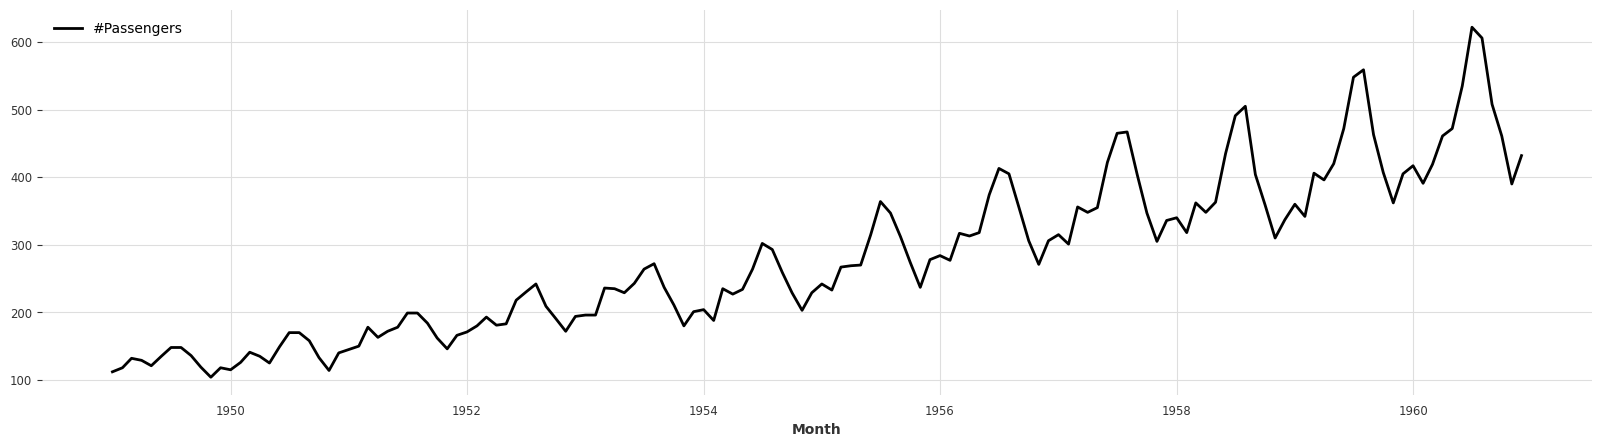

In [51]:
plt.figure(figsize=(20,5))
data.plot()
plt.show()

(114, 1)
(30, 1)


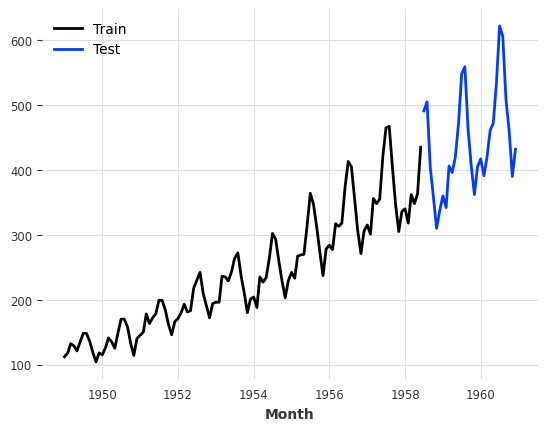

In [52]:
train, test = data.split_before(0.80)
train.plot(label="Train")
test.plot(label="Test")
print(train.values().shape)
print(test.values().shape)

# AutoARIMA

In [53]:
from darts.models.forecasting.auto_arima import AutoARIMA

In [54]:
model = AutoARIMA()
model.fit(train)
pred = model.predict(n=30)

<Axes: xlabel='Month'>

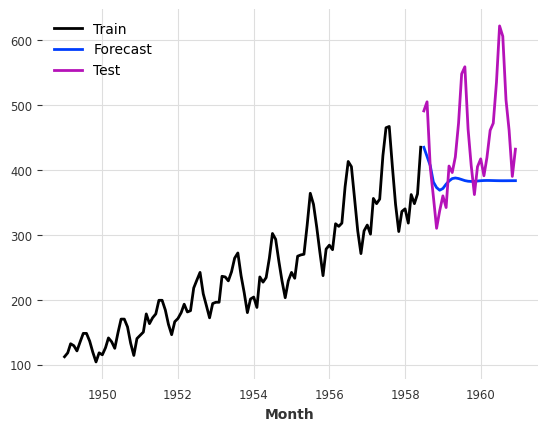

In [55]:
train.plot(label='Train')
pred.plot(label='Forecast')
test.plot(label='Test')

In [56]:
print(f"RMSE: {np.sqrt(mean_squared_error(test.values(), pred.values()))}")
print(f" MAE: {mean_absolute_error(test.values(), pred.values())}")

RMSE: 93.28497894867839
 MAE: 68.52293402958395


# ARIMA

In [57]:
from darts.models.forecasting.arima import ARIMA

In [58]:
model = ARIMA(p=12,d=2,q=11)
model.fit(train)
pred = model.predict(n=30)

/home/aditya/Documents/Time-forecasting-ESN/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aditya/Documents/Time-forecasting-ESN/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Month'>

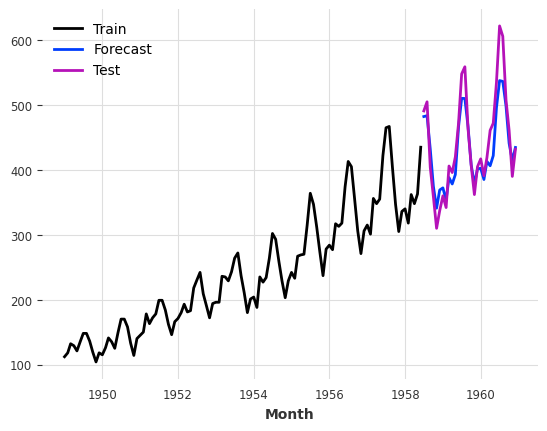

In [59]:
train.plot(label='Train')
pred.plot(label='Forecast')
test.plot(label='Test')

In [60]:
print(f"RMSE: {np.sqrt(mean_squared_error(test.values(), pred.values()))}")
print(f" MAE: {mean_absolute_error(test.values(), pred.values())}")

RMSE: 31.42200393763057
 MAE: 23.946614913601064


# SARIMA

In [61]:
model = ARIMA(p=2,d=1,q=2, seasonal_order=(2,1,1,12))
model.fit(train)
pred = model.predict(n=30)

<Axes: xlabel='Month'>

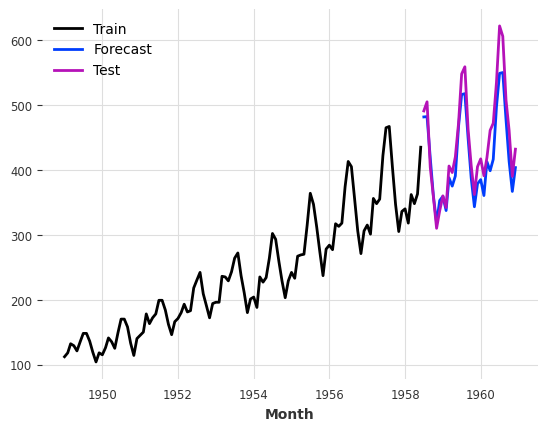

In [62]:
train.plot(label='Train')
pred.plot(label='Forecast')
test.plot(label='Test')

In [63]:
print(f"RMSE: {np.sqrt(mean_squared_error(test.values(), pred.values()))}")
print(f" MAE: {mean_absolute_error(test.values(), pred.values())}")

RMSE: 31.894243370604986
 MAE: 26.171567361618465


In [64]:
from darts.models import NBEATSModel

In [65]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=50, random_state=123)
model.fit(train)
pred = model.predict(n=30, series=train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

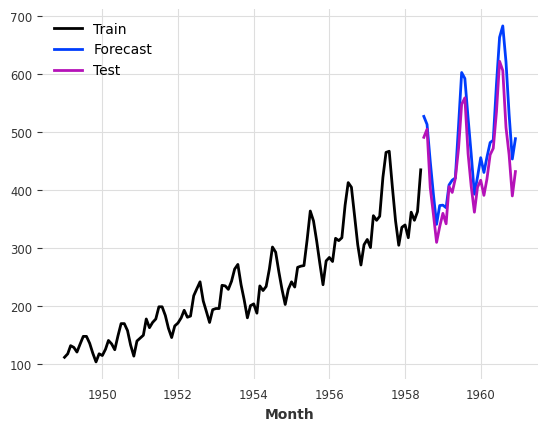

In [66]:
train.plot(label='Train')
pred.plot(label='Forecast')
test.plot(label='Test')

In [67]:
print(f"RMSE: {np.sqrt(mean_squared_error(test.values(), pred.values()))}")
print(f" MAE: {mean_absolute_error(test.values(), pred.values())}")

RMSE: 45.42146506607033
 MAE: 39.00406476537884
